## Практическое задание к уроку № 2 по теме "Масштабирование признаков. L1- и L2-регуляризация. Стохастический градиентный спуск".

#### Задание 1.  
*Сгенерировать датасет при помощи `sklearn.datasets.make_regression` и обучить линейную модель при помощи градиентного спуска и  стохастического градиентного спуска. Построить графики среднеквадратичной ошибки от числа итераций для обоих методов на одном рисунке, сделать выводы о разнице скорости сходимости каждого из методов.*

In [1]:
import numpy as np
from sklearn import datasets

Определим функцию для расчёта ошибки и создадим класс для модели градиентного спуска:

In [2]:
def calc_mse(X, w, y):
    return sum((X @ w - y) ** 2) / len(y)

In [3]:
class GradientDescent():
    
    def __init__(self):
        self.w = None
        self.errors = None
        
    def fit(self, X, y, iterations=100, eta=0.01, stochastic=False, verbose=False, random_state=0):
        
        self.errors = []
        n = X.shape[0]
        np.random.seed(random_state)
        self.w = np.random.randn(X.shape[1])
        
        for i in range(iterations + 1):
            err = calc_mse(X, self.w, y)
            self.errors.append(err)
            if stochastic:
                idx = np.random.randint(n)
                A = X[idx, :].copy()
                b = y[idx].copy()
            else:
                A = X.copy()
                b = y.copy()
            
            self.w = self.w - eta * 2/n * np.reshape(A.T, (X.shape[1], -1)) @ (np.reshape(A, (-1, X.shape[1])) @ self.w - b)
            
            if verbose and (i % (iterations / 10) == 0):
                print(f'eta: {eta}, iterations: {i}\nweights: {self.w}, mse: {err}\n')
    
    def predict(self, X):
        return X @ self.w

Создадим класс для стандартизации признаков:

In [4]:
class StandardScaler():
    
    def __init__(self):
        self.std = None
        self.mean = None
    
    def fit(self, X):
        self.std = np.std(X, axis=0)
        self.mean = np.mean(X, axis=0)
    
    def transform(self, X):
        return (X - self.mean) / self.std

Сгенерируем датасет:

In [5]:
X, y, w_true = datasets.make_regression(n_samples=1000,
                                        n_features=2,
                                        n_informative=2,
                                        n_targets=1,
                                        noise=5,
                                        coef=True,
                                        random_state=29)

Стандартизируем признаки:

In [6]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Обучим модели:

In [7]:
model_GD = GradientDescent()
model_SGD = GradientDescent()

In [8]:
%%time
model_GD.fit(X, y, 
             iterations=500, 
             eta=0.03, 
             stochastic=False,
             verbose=False, 
             random_state=29)

CPU times: total: 46.9 ms
Wall time: 42.9 ms


In [9]:
%%time
model_SGD.fit(X, y,
              iterations=100000,
              eta=0.03, 
              stochastic=True, 
              verbose=False, 
              random_state=29)

CPU times: total: 8.09 s
Wall time: 8.11 s


In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')

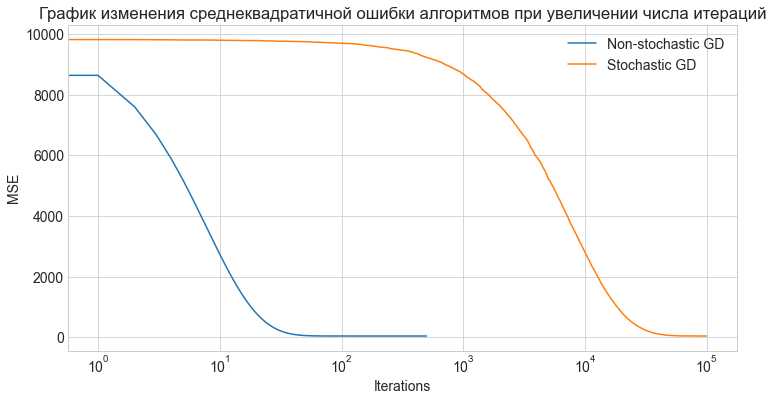

In [11]:
plt.figure(figsize=(12,6))
plt.plot(range(len(model_GD.errors)), model_GD.errors, label='Non-stochastic GD')
plt.plot(range(len(model_SGD.errors)), model_SGD.errors, label='Stochastic GD')

plt.title('График изменения среднеквадратичной ошибки алгоритмов при увеличении числа итераций')
plt.xlabel('Iterations')
plt.xscale(value='log')
plt.ylabel('MSE')
plt.legend()

plt.show()

<u>Вывод:</u> Стохастический градиентный спуск потребовал почти в 1000 раз больше итераций для сходимости, чем обычный, и почти в 200 раз больше времени на обучение. Данные алгоритмы сравнивались при одинаковом параметре `eta` для наглядности, но очевидно, что в случае со стохастическим градиентным спуском можно было задавать большее значение шага. В нашем примере мы всё равно держали в памяти всю матрицу данных, поэтому не увидели главного преимущества стохастического градиентного спуска - необходимость держать в памяти только часть датасета, а не весь целиком.

#### Задание 2.  
*Дан алгоритм градиентного спуска с L2 регуляризацией. Добавить в него L1 регуляризацию. Сравнить влияние коэффициентов регуляризации L1 и L2 на величину весов для примера из урока (лучше графически).*  

Добавим в функцию возможность задать вид регуляризации:

In [12]:
def eval_model_reg(X, y, iterations, eta=1e-4, lambda_=1e-8, reg_type=2, verbose=False):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(iterations + 1):
        err = calc_mse(X, w, y)
        if reg_type == 2:
            w -= eta * (1/n * 2 * np.dot(X.T, (X @ w - y)) + 2 * lambda_ * w)
        elif reg_type == 1:
            w -= eta * (1/n * 2 * np.dot(X.T, (X @ w - y)) + lambda_ * w / abs(w))
        if verbose and i % (iterations / 10) == 0:
            print(f'{i}: weights={w}, MSE={err:.3f}')
    return w

Добавим к готовому графику весов с L2-регуляризацией L1-регуляризацию:

In [13]:
w_list_l1 = []
w_list_l2 = []
l_list_l2 = []
l_list_l1 = []
error_list_l1 = []
error_list_l2 = []

for l in np.logspace(start=-4, stop=1.4, num=20):
    l_list_l2.append(l)
    w_new_l2 = eval_model_reg(X, y, iterations=1000, eta=1e-2, lambda_=l, reg_type=2)
    w_list_l2.append(w_new_l2)
    error_list_l2.append(calc_mse(X, w_new_l2, y))

for l in np.logspace(start=-3, stop=2.1, num=20):
    l_list_l1.append(l)
    w_new_l1 = eval_model_reg(X, y, iterations=1000, eta=1e-2, lambda_=l, reg_type=1)
    w_list_l1.append(w_new_l1)
    error_list_l1.append(calc_mse(X, w_new_l1, y))
    
weights_l1 = np.array(w_list_l1)
weights_l2 = np.array(w_list_l2)
errors_l2 = np.array(error_list_l2)
errors_l1 = np.array(error_list_l1)

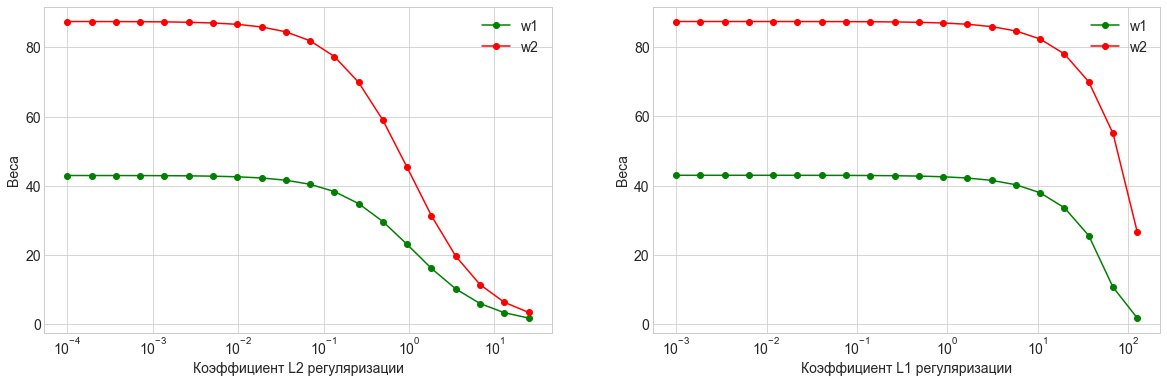

In [14]:
fig, ax = plt.subplots(1, 2)
ax1, ax2 = ax.flatten()
fig.set_size_inches(20, 6)

ax1.set_xscale('log')
ax1.plot(l_list_l2, weights_l2[:, 0], 'go-', label=r'w1')
ax1.plot(l_list_l2, weights_l2[:, 1], 'ro-', label=r'w2')
ax1.set_xlabel('Коэффициент L2 регуляризации')
ax1.set_ylabel('Веса')
ax1.legend()

ax2.set_xscale('log')
ax2.plot(l_list_l1, weights_l1[:, 0], 'go-', label=r'w1')
ax2.plot(l_list_l1, weights_l1[:, 1], 'ro-', label=r'w2')
ax2.set_xlabel('Коэффициент L1 регуляризации')
ax2.set_ylabel('Веса')
ax2.legend()

plt.show()

Посмотрим, как меняется ошибка при изменении коэффициентов регуляризации:

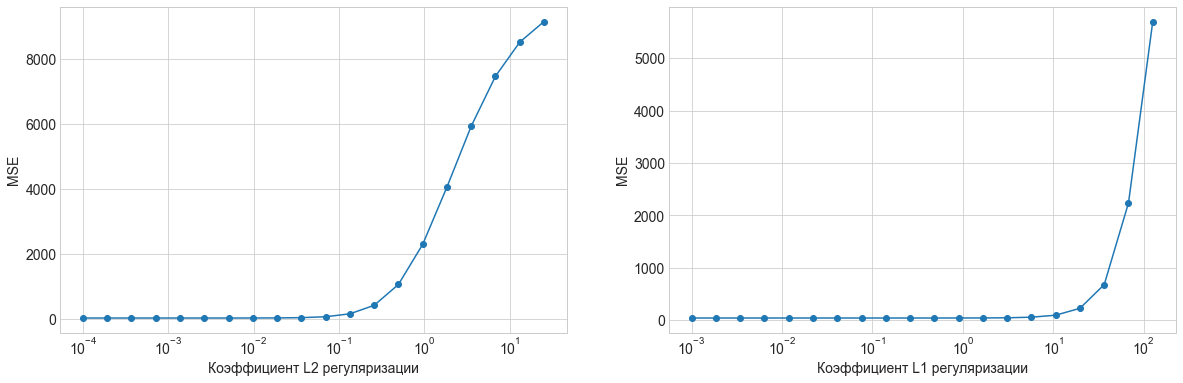

In [15]:
fig, ax = plt.subplots(1, 2)
ax1, ax2 = ax.flatten()
fig.set_size_inches(20, 6)

ax1.set_xscale('log')
ax1.plot(l_list_l2, errors_l2, 'o-')
ax1.set_xlabel('Коэффициент L2 регуляризации')
ax1.set_ylabel('MSE')

ax2.set_xscale('log')
ax2.plot(l_list_l1, errors_l1, 'o-')
ax2.set_xlabel('Коэффициент L1 регуляризации')
ax2.set_ylabel('MSE')

plt.show()

<u>Вывод:</u> Проведена оценка изменения весов модели линейной регрессии, а также её среднеквадратичной ошибки при L1 и L2 регуляризации. Графически показана зависимость этих величин от коэффициентов регуляризации. Из графиков можно сделать вывод, что для L1-регуляризации требуется более высокий коэффициент регуляризации: резкое падение весов и увеличение ошибки L2-регуляризации началось при коэффициенте больше 0,1, тогда как существенное влияние L1-регуляризации началось при коэффициенте больше 10. Также видно, что веса при L1-регуляризации падают более стремительно, обнуляя в итоге весовые коэффициенты, тогда как при L2-регуляризации падение весов замедляется.